In [12]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from imblearn import over_sampling, under_sampling

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression

%matplotlib inline


print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

numpy version :  1.20.1
pandas version :  1.2.4
seaborn version :  0.11.1


In [13]:
df_mentah = pd.read_excel('youtube_statistics.xlsx')
df_mentah.head()

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description,No_tags,desc_len,len_title,publish_date
0,2017-11-14,Sharry Mann: Cute Munda ( Song Teaser) | Parmi...,Lokdhun Punjabi,1,12:20:39,"sharry mann|""sharry mann new song""|""sharry man...",1096327,33966,798,882,False,False,False,Presenting Sharry Mann latest Punjabi Song Cu...,15,920,81,2017-11-12
1,2017-11-14,"पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं...",HJ NEWS,25,05:43:56,"पीरियड्स के समय|""पेट पर पति करता ऐसा""|""देखकर द...",590101,735,904,0,True,False,False,"पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं...",19,2232,58,2017-11-13
2,2017-11-14,Stylish Star Allu Arjun @ ChaySam Wedding Rece...,TFPC,24,15:48:08,Stylish Star Allu Arjun @ ChaySam Wedding Rece...,473988,2011,243,149,False,False,False,Watch Stylish Star Allu Arjun @ ChaySam Weddin...,14,482,58,2017-11-12
3,2017-11-14,Eruma Saani | Tamil vs English,Eruma Saani,23,07:08:48,"Eruma Saani|""Tamil Comedy Videos""|""Films""|""Mov...",1242680,70353,1624,2684,False,False,False,This video showcases the difference between pe...,20,263,30,2017-11-12
4,2017-11-14,why Samantha became EMOTIONAL @ Samantha naga ...,Filmylooks,24,01:14:16,"Filmylooks|""latest news""|""telugu movies""|""telu...",464015,492,293,66,False,False,False,why Samantha became EMOTIONAL @ Samantha naga ...,11,753,88,2017-11-13


# Nomor 1 - EDA dan Preprocessing

## EDA

In [14]:
df_mentah.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36791 entries, 0 to 36790
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trending_date           36791 non-null  object        
 1   title                   36791 non-null  object        
 2   channel_title           36791 non-null  object        
 3   category_id             36791 non-null  int64         
 4   publish_time            36791 non-null  object        
 5   tags                    36791 non-null  object        
 6   views                   36791 non-null  int64         
 7   likes                   36791 non-null  int64         
 8   dislikes                36791 non-null  int64         
 9   comment_count           36791 non-null  int64         
 10  comments_disabled       36791 non-null  bool          
 11  ratings_disabled        36791 non-null  bool          
 12  video_error_or_removed  36791 non-null  bool  

In [15]:
# convert to data type datetime
df_mentah['trending_date'] = pd.to_datetime(df_mentah['trending_date'])
df_mentah['publish_date'] = pd.to_datetime(df_mentah['publish_date'])
df_mentah['daysofpublish'] = df_mentah['publish_date'].dt.strftime('%a')
df_mentah['daysoftrend'] = df_mentah['trending_date'].dt.strftime('%a')


# # convert to data type datetime (hours, minute, second)
# df_mentah['publish_time'] = pd.to_datetime(df_mentah['publish_time']).dt.time

In [16]:
# mengambil kolom numerik

# numerik
num_dtypes = ['int64','float64', 'int32']
num_df = df_mentah.select_dtypes(num_dtypes)
numerik = num_df.columns

df_mentah[numerik].describe()

,category_id,views,likes,dislikes,comment_count,No_tags,desc_len,len_title
count,36791.000000,3.679100e+04,3.679100e+04,3.679100e+04,36791.000000,36791.000000,36791.000000,36791.000000
mean,21.552173,1.071490e+06,2.745069e+04,1.685363e+03,2714.022043,18.938463,923.079123,70.609361
std,6.586716,3.207149e+06,9.783129e+04,1.619732e+04,14978.114328,9.843531,815.038867,22.409174
min,1.000000,4.024000e+03,0.000000e+00,0.000000e+00,0.000000,1.000000,3.000000,5.000000
25%,23.000000,1.256040e+05,8.790000e+02,1.090000e+02,83.000000,12.000000,368.000000,53.000000
50%,24.000000,3.078360e+05,3.126000e+03,3.310000e+02,336.000000,19.000000,677.000000,74.000000
75%,24.000000,8.066315e+05,1.409500e+04,1.032000e+03,1314.500000,25.000000,1237.000000,91.000000
max,43.000000,1.254322e+08,2.912710e+06,1.545017e+06,827755.000000,72.000000,5136.000000,100.000000


In [17]:
# # mengambil kolom kategori
cat_dtypes = ['object', 'bool']
cat_df = df_mentah.select_dtypes(cat_dtypes)
kategori = cat_df.columns

df_mentah[kategori].describe()

,title,channel_title,publish_time,tags,comments_disabled,ratings_disabled,video_error_or_removed,description,daysofpublish,daysoftrend
count,36791,36791,36791,36791,36791,36791,36791,36746,36791,36791
unique,16431,1390,12375,12463,2,2,2,13979,7,7
top,Mission: Impossible - Fallout (2018) - Officia...,VikatanTV,04:30:00,[none],False,False,False,Subscribers Link: http://bit.ly/2qb69dZ\n\nCon...,Fri,Sat
freq,19,284,333,1120,35611,36034,36780,166,6097,5544


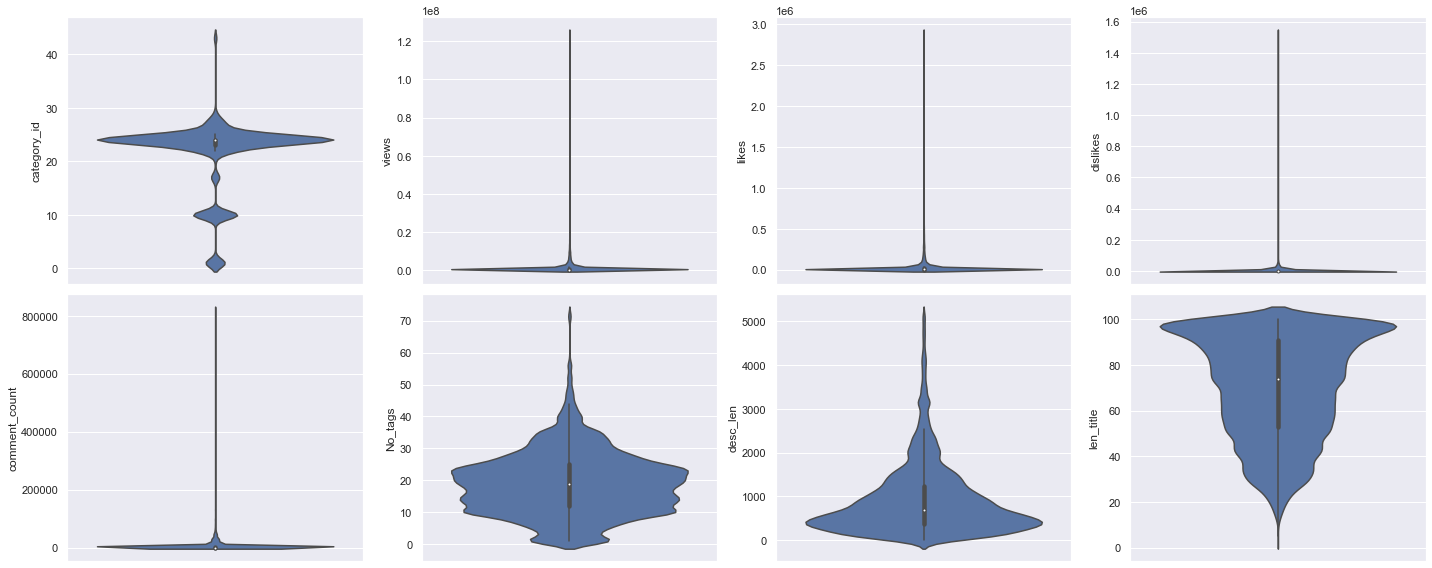

In [18]:
plt.figure(figsize=(20,8))

for i in range(0, len(numerik)):
    plt.subplot(2, round(len(numerik)/2), i+1)
    sns.violinplot(y=df_mentah[numerik[i]], orient='v')
    plt.tight_layout()


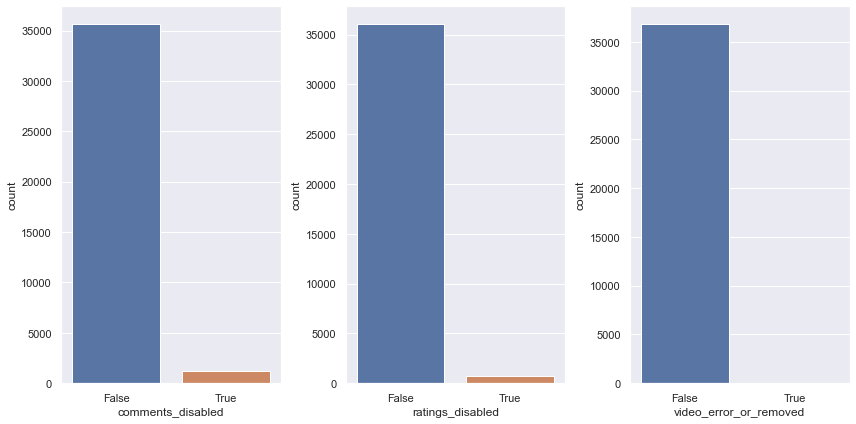

In [19]:
plt.figure(figsize=(12,6))
    
for i,j in enumerate(df_mentah.select_dtypes(['bool']).columns):
    plt.subplot(1, round(len(df_mentah.select_dtypes(['bool']).columns)), i+1)
    sns.countplot(df_mentah[j], orient='v')
    plt.tight_layout()

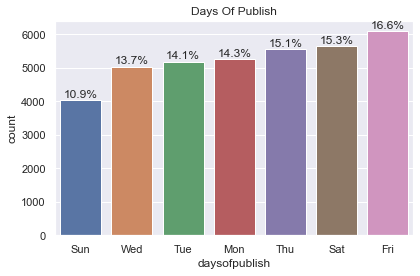

In [20]:
sns.set(style='darkgrid')
plt.title('Days Of Publish')
ax = sns.countplot(data=df_mentah, x='daysofpublish',order=df_mentah['daysofpublish'].value_counts(ascending=True).index)
total = len(df_mentah)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

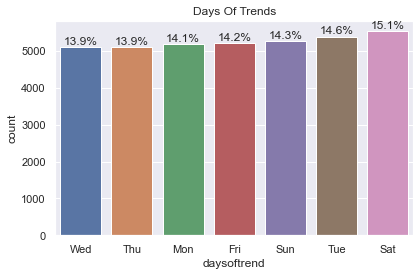

In [21]:
sns.set(style='darkgrid')
plt.title('Days Of Trends')
ax = sns.countplot(data=df_mentah, x='daysoftrend',order=df_mentah['daysoftrend'].value_counts(ascending=True).index)
total = len(df_mentah)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

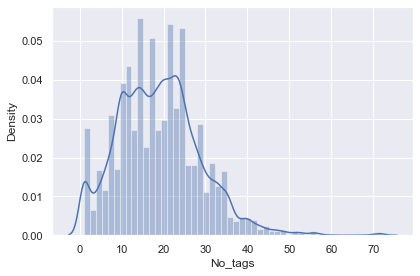

In [22]:
ax = sns.distplot(df_mentah['No_tags'])
plt.tight_layout()
plt.show()

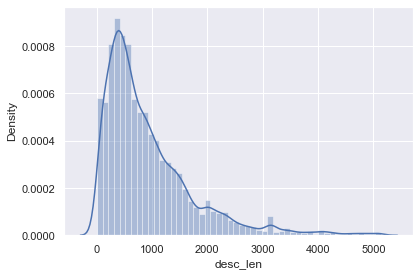

In [23]:
ax = sns.distplot(df_mentah['desc_len'])
plt.tight_layout()
# print(df_mentah['desc_len'].describe())
plt.show()

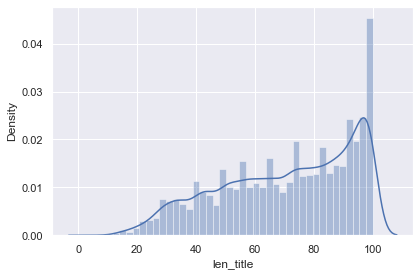

In [10]:
ax = sns.distplot(df_mentah['len_title'])
plt.tight_layout()
# print(df_mentah['len_title'].describe())
plt.show()

<AxesSubplot:>

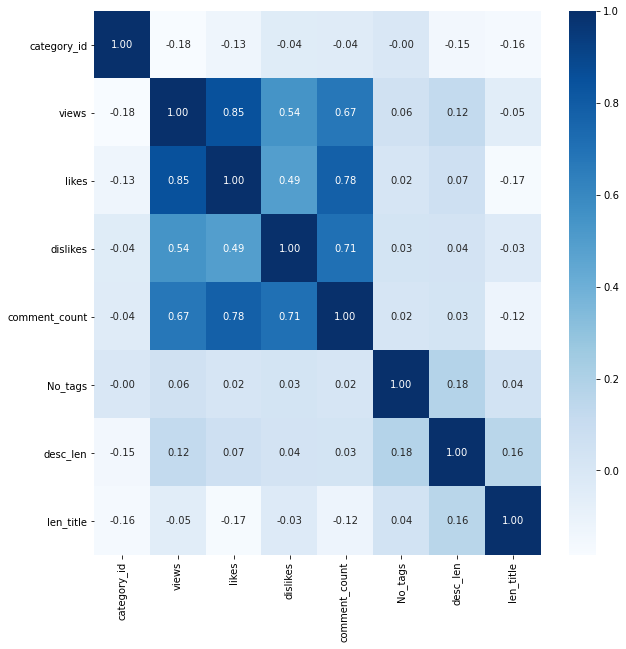

In [59]:
plt.figure(figsize=(10,10))
sns.heatmap(df_mentah[numerik].corr(), cmap='Blues', annot=True, fmt='.2f')

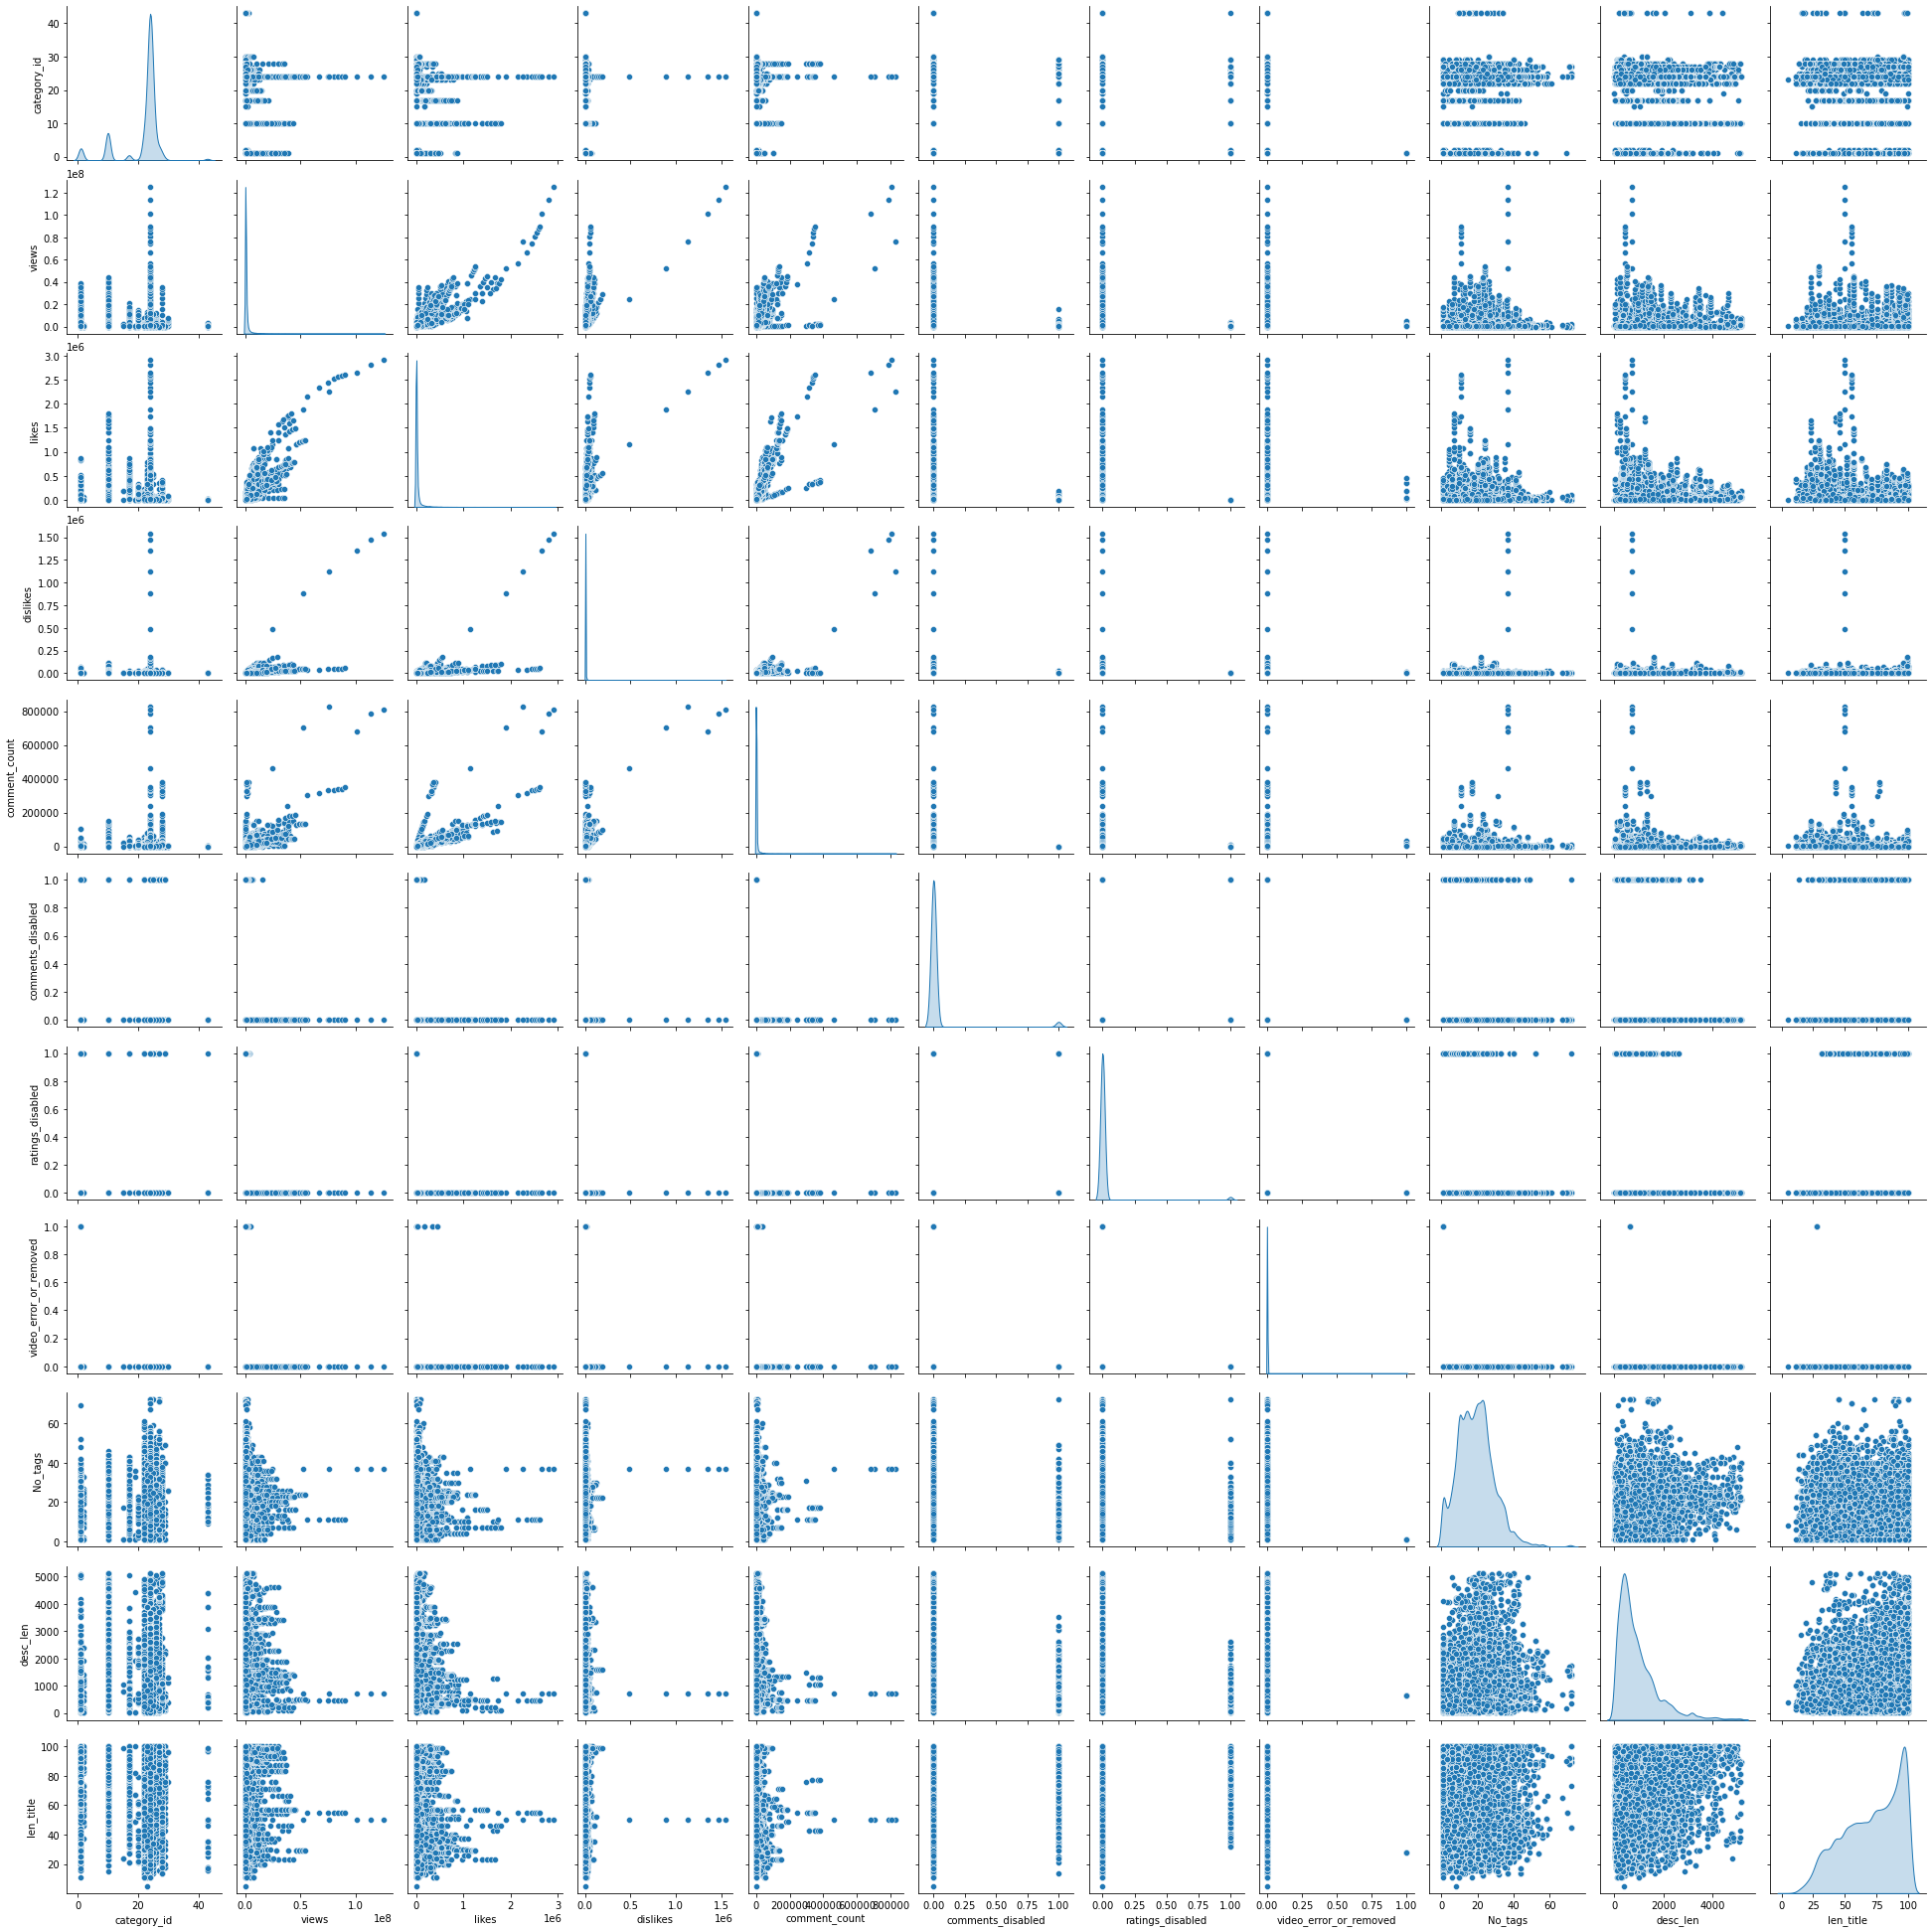

In [60]:
sns.pairplot(df_mentah, diag_kind='kde')

## Pre-processing

### Menetukan Target

In [61]:
df_mentah['target_views'] = df_mentah.apply(lambda x: 1 if x['views'] > df_mentah['views'].median() else 0, axis=1)

### Missing data

In [62]:
df_mentah.isna().sum()

trending_date              0
title                      0
channel_title              0
category_id                0
publish_time               0
tags                       0
views                      0
likes                      0
dislikes                   0
comment_count              0
comments_disabled          0
ratings_disabled           0
video_error_or_removed     0
description               45
No_tags                    0
desc_len                   0
len_title                  0
publish_date               0
target_views               0
dtype: int64

In [63]:
df_mentah.dropna(inplace=True)

### Duplicated

In [64]:
df_mentah.duplicated().sum()


4228

In [65]:
df_mentah.drop_duplicates(keep='first', inplace=True)

### Outliers

#### IQR

In [66]:
print(f'Jumlah baris sebelum memfilter outlier: {len(df_mentah)}')

filtered_entries = np.array([True] * len(df_mentah))
for col in numerik:
    Q1 = df_mentah[col].quantile(0.25)
    Q3 = df_mentah[col].quantile(0.75)
    IQR = Q3 - Q1
    low_limit = Q1 - (IQR * 1.5)
    high_limit = Q3 + (IQR * 1.5)

    filtered_entries = ((df_mentah[col] >= low_limit) & (df_mentah[col] <= high_limit)) & filtered_entries
    
df_iqr = df_mentah[filtered_entries]

print(f'Jumlah baris setelah memfilter outlier: {len(df_iqr)}')

Jumlah baris sebelum memfilter outlier: 32518
Jumlah baris setelah memfilter outlier: 19577


In [67]:
# mengambil kolom numerik

# numerik
num_dtypes = ['int64','float64', 'int32']
num_df = df_iqr.select_dtypes(num_dtypes)
numerik = num_df.columns

df_iqr[numerik].describe()

,category_id,views,likes,dislikes,comment_count,No_tags,desc_len,len_title,target_views
count,19577.000000,1.957700e+04,19577.000000,19577.000000,19577.000000,19577.000000,19577.000000,19577.000000,19577.000000
mean,23.948971,2.931810e+05,3302.414517,320.387802,350.869949,17.736374,703.374419,71.778873,0.321040
std,0.820595,2.936436e+05,4901.832602,375.270220,480.964281,8.918255,530.289980,20.962971,0.466888
min,22.000000,4.024000e+03,0.000000,0.000000,0.000000,1.000000,4.000000,5.000000,0.000000
25%,24.000000,9.449100e+04,478.000000,72.000000,42.000000,10.000000,304.000000,56.000000,0.000000
50%,24.000000,1.870180e+05,1311.000000,180.000000,152.000000,18.000000,568.000000,74.000000,0.000000
75%,24.000000,3.822320e+05,3822.000000,419.000000,456.000000,24.000000,975.000000,91.000000,1.000000
max,25.000000,1.677154e+06,29587.000000,2213.000000,2861.000000,44.000000,2506.000000,100.000000,1.000000


In [68]:
# kategori
cat_dtypes = ['object', 'bool']
cat_df = df_iqr.select_dtypes(cat_dtypes)
kategori = df_iqr.columns

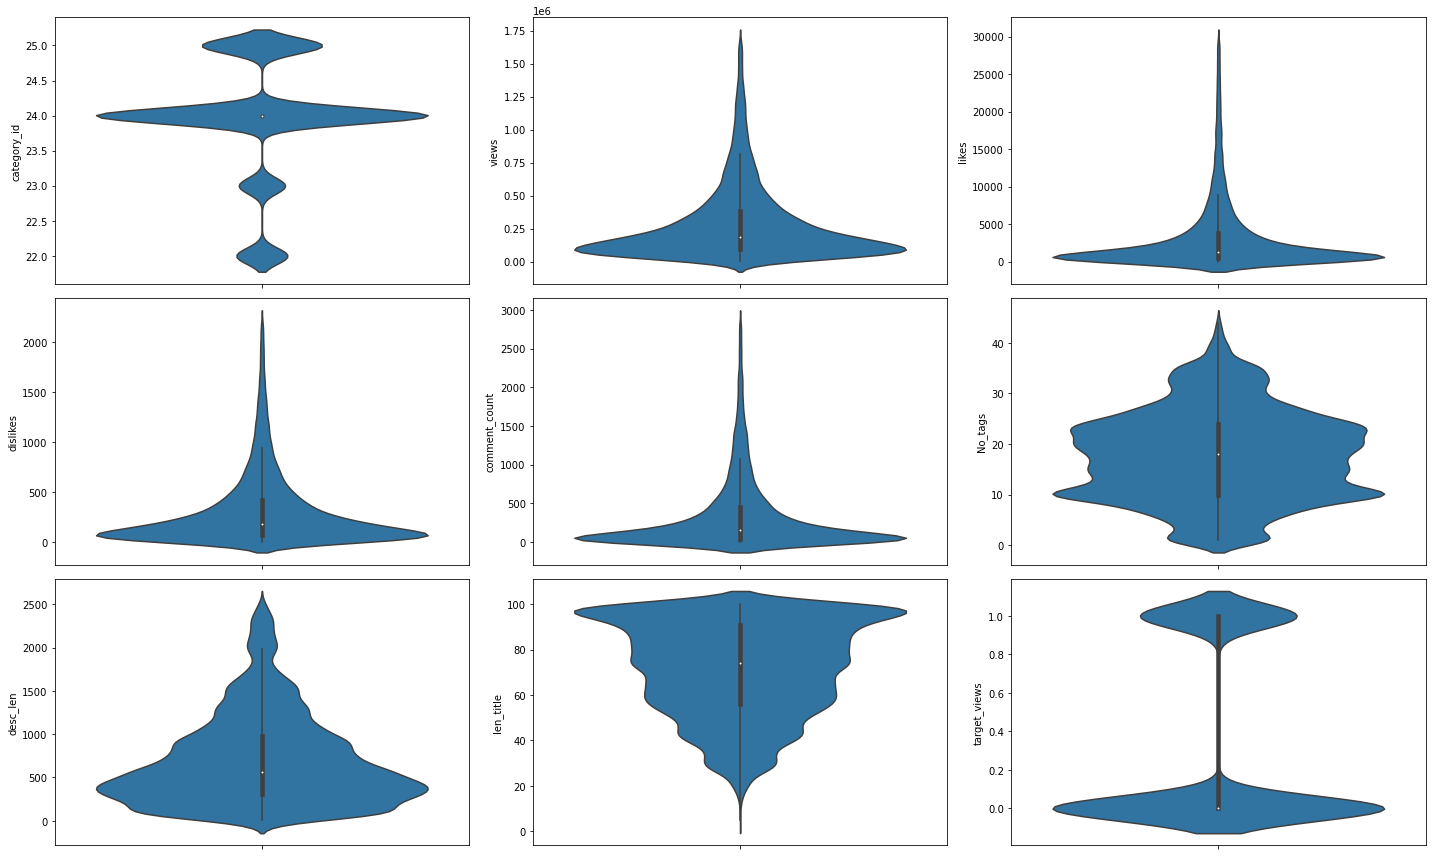

In [69]:
plt.figure(figsize=(20,12))

for i in range(0, len(numerik)):
    plt.subplot(3, round(len(numerik)/3), i+1)
    sns.violinplot(y=df_iqr[numerik[i]], orient='v')
    plt.tight_layout()


### Feature Encoding

In [70]:
df_iqr.select_dtypes(['bool']).columns

Index(['comments_disabled', 'ratings_disabled', 'video_error_or_removed'], dtype='object')

In [71]:
for i in df_iqr.select_dtypes(['bool']).columns:
    df_iqr[i+'_label']= LabelEncoder().fit_transform(df_iqr[i])

### Normalization

- standardization bila kita tahu data punya sebaran normal/gaussian
- standardization bila model yang kita pakai punya asumsi tentang normalitas (e.g. regresi linear)
- normalization apabila tidak memenuhi 2 kriteria di atas


In [72]:
# mengambil kolom numerik dan kategori

# numerik
num_dtypes = ['int64','float64', 'int32']
num_df = df_iqr.select_dtypes(num_dtypes)
numerik = num_df.columns

# kategori
cat_dtypes = ['object', 'bool']
cat_df = df_iqr.select_dtypes(cat_dtypes)
kategori = df_iqr.columns

In [73]:
# Feature Scaler Using Minmax()
scaler = MinMaxScaler()
scaler.fit(df_iqr[numerik])
df_scale = scaler.transform(df_iqr[numerik])

# Convert the NumPy Array scale_x_train to DataFrame
df_scale = pd.DataFrame(df_scale, columns=df_iqr[numerik].columns)
df_scale.reset_index(inplace=True, drop=True)
df_scale

,category_id,views,likes,dislikes,comment_count,No_tags,desc_len,len_title,target_views,comments_disabled_label,ratings_disabled_label,video_error_or_removed_label
0,1.000000,0.350288,0.024842,0.408495,0.000000,0.418605,0.890488,0.557895,1.0,1.0,0.0,0.0
1,0.666667,0.280889,0.067969,0.109806,0.052080,0.302326,0.191047,0.557895,1.0,0.0,0.0,0.0
2,0.666667,0.274928,0.016629,0.132399,0.023069,0.232558,0.299361,0.873684,1.0,0.0,0.0,0.0
3,0.666667,0.068255,0.017575,0.023949,0.008039,0.465116,0.201839,0.968421,0.0,0.0,0.0,0.0
4,1.000000,0.090884,0.024200,0.023949,0.000000,0.441860,0.341327,0.842105,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
19572,0.666667,0.163279,0.029371,0.101672,0.019574,0.720930,0.956035,0.494737,0.0,0.0,0.0,0.0
19573,0.333333,0.015248,0.052692,0.028920,0.032856,0.581395,0.135492,0.273684,0.0,0.0,0.0,0.0
19574,0.000000,0.108882,0.028898,0.038861,0.008738,0.581395,0.402078,0.547368,0.0,0.0,0.0,0.0
19575,1.000000,0.084529,0.021192,0.045188,0.011884,0.465116,0.270584,0.852632,0.0,0.0,0.0,0.0


### Imbalance Class

In [74]:
train, test = train_test_split(df_iqr, test_size=0.30, random_state=42)
train['target_views'].value_counts()


0    9324
1    4379
Name: target_views, dtype: int64

In [75]:
# memindahkan kolom target ke paling kanan
cols = train[numerik].columns.to_list()
cols.remove('target_views')
cols.append('target_views')

In [76]:
X = train[cols[:-1]]
y = train[cols[-1:]]
X_over, y_over = over_sampling.SMOTE().fit_resample(X, y)

# Nomor 2 - Feature Engineering

# Nomor 3

## Feature Importance

In [77]:
# Seleksi menggunakan - pandas pearson correlation 
Y = df_scale[cols]
pxs = Y.corr(method='pearson', min_periods=0.2)
pxs = pxs.abs()
pxs.sort_values(by='target_views', inplace=True, ascending=False)
pxs


,category_id,views,likes,dislikes,comment_count,No_tags,desc_len,len_title,comments_disabled_label,ratings_disabled_label,video_error_or_removed_label,target_views
target_views,0.050170,0.782359,0.390331,0.558358,0.326203,0.058077,0.059655,0.008013,0.023773,0.008621,NaN,1.000000
views,0.035599,1.000000,0.434275,0.657941,0.362101,0.083772,0.069884,0.011471,0.026302,0.004435,NaN,0.782359
dislikes,0.044234,0.657941,0.538835,1.000000,0.560068,0.092335,0.013240,0.032646,0.012774,0.136796,NaN,0.558358
likes,0.154642,0.434275,1.000000,0.538835,0.717531,0.128879,0.007971,0.209747,0.082404,0.107948,NaN,0.390331
comment_count,0.043904,0.362101,0.717531,0.560068,1.000000,0.106158,0.000976,0.151497,0.142244,0.065293,NaN,0.326203
desc_len,0.091010,0.069884,0.007971,0.013240,0.000976,0.107501,1.000000,0.132642,0.025904,0.038874,NaN,0.059655
No_tags,0.039100,0.083772,0.128879,0.092335,0.106158,1.000000,0.107501,0.041636,0.017197,0.067349,NaN,0.058077
category_id,1.000000,0.035599,0.154642,0.044234,0.043904,0.039100,0.091010,0.084366,0.019689,0.020723,NaN,0.050170
comments_disabled_label,0.019689,0.026302,0.082404,0.012774,0.142244,0.017197,0.025904,0.114932,1.000000,0.250769,NaN,0.023773
ratings_disabled_label,0.020723,0.004435,0.107948,0.136796,0.065293,0.067349,0.038874,0.061215,0.250769,1.000000,NaN,0.008621


<AxesSubplot:xlabel='target_views', ylabel='index'>

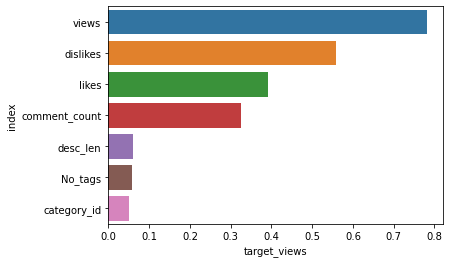

In [78]:
# nilai korelasi terhadap target 
pxs_scor_accuracy = pxs.iloc[1:8,-1]
pxs_scor_accuracy
sns.barplot(y='index', x='target_views', data=pxs_scor_accuracy.reset_index())

In [79]:
feature_importance = pxs_scor_accuracy.reset_index()['index'][1:6]

## Point A

In [80]:
def eval_regression(model, pred, xtrain, ytrain, xtest, ytest):
    # print("train Accuracy : %.4f" % model.score(xtrain,ytrain))
    # print("test Accuracy : %.4f" % model.score(xtest,ytest))
    mae = mean_absolute_error(ytest, pred)
    mse = mean_squared_error(ytest, pred, squared=False)
    r2 = r2_score(ytest, pred)
    print("MAE: %.4f" % mae) # The MAE
    print("RMSE: %.4f" % mse) # The RMSE
    print('R2 score: %.4f' % r2) # Explained variance score: 1 is perfect prediction

    return [mae,mse,r2]

### Get X and Y Data Train

In [81]:
import statsmodels.api as sm


In [82]:
xtrain_SMOTE = X_over[feature_importance]
ytrain_SMOTE = y_over
xtest = test[cols[:-1]][feature_importance]
ytest = test[cols[-1:]]

In [83]:
nilai_eval = []

### Linear Regression

In [84]:
lr = LinearRegression()
lr.fit(xtrain_SMOTE[feature_importance], ytrain_SMOTE)
pred = lr.predict(xtest)
nilai_eval.append(eval_regression(lr, pred, xtrain_SMOTE, ytrain_SMOTE, xtest, ytest))

MAE: 0.3623
RMSE: 0.4020
R2 score: 0.2626


### Decision Tree

In [85]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(xtrain_SMOTE[feature_importance], ytrain_SMOTE)
pred = dt.predict(xtest)
nilai_eval.append(eval_regression(dt, pred, xtrain_SMOTE, ytrain_SMOTE, xtest, ytest))

MAE: 0.2000
RMSE: 0.4470
R2 score: 0.0886


### Random Forest

In [86]:
rf = RandomForestRegressor(random_state=42)
rf.fit(xtrain_SMOTE[feature_importance], ytrain_SMOTE)
pred = rf.predict(xtest)
nilai_eval.append(eval_regression(rf, pred, xtrain_SMOTE, ytrain_SMOTE, xtest, ytest))

MAE: 0.2059
RMSE: 0.3286
R2 score: 0.5075


### Support Vector Regressor

In [87]:
svr = SVR()
svr.fit(xtrain_SMOTE[feature_importance], ytrain_SMOTE)
pred = svr.predict(xtest)
nilai_eval.append(eval_regression(svr, pred, xtrain_SMOTE, ytrain_SMOTE, xtest, ytest))

MAE: 0.2729
RMSE: 0.3888
R2 score: 0.3102


In [88]:
nilai_eval = pd.DataFrame(nilai_eval)
nilai_eval.columns = ['MAE', 'RMSE', 'R2']
nilai_eval.set_axis(['Linear Regression', 'Decision Tree', 'Random Forest', 'Support Vector Regressor'], inplace=True)

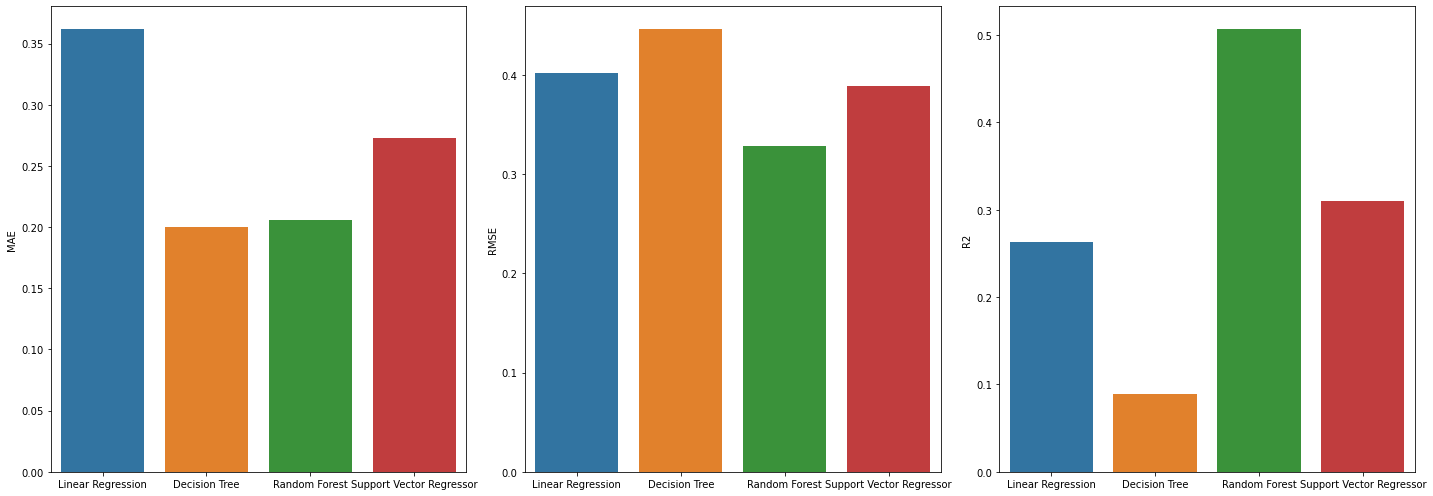

In [89]:
plt.figure(figsize=(20,7))
    
for i in range(0, nilai_eval.shape[1]):
    plt.subplot(1, nilai_eval.shape[1], i+1)
    sns.barplot(x=nilai_eval.index, y=nilai_eval.columns[i], data=nilai_eval)
    plt.tight_layout()



## Point B

In [90]:
nilai_eval_tuning = []

### Linear Regression

In [91]:
# # alpha = [0.01, 0.1, 1, 2, 3, 4]
# solver = ['auto', 'lsqr', 'sag']
# penalty = ['none', 'l1', 'l2', 'elasticnet']

# hyper = dict(solver=solver, penalty=penalty)

# clf = GridSearchCV(lr, hyper, cv=5)

# # Fitting Model
# best_model = clf.fit(xtrain_SMOTE, ytrain_SMOTE)
# pred = best_model.predict(xtest)
# eval_regression(best_model, pred, xtrain_SMOTE, ytrain_SMOTE, xtest, ytest)

### Decision Tree

In [92]:
# parameters={"splitter":["best","random"],
#             "max_depth" : [1,3,5],
#            "min_samples_leaf":[1,2,3],
#            "min_weight_fraction_leaf":[0.1,0.2,0.3],
#            "max_features":["auto","log2","sqrt"],
#            "max_leaf_nodes":[None,10,20,30] }

# clf = GridSearchCV(dt, parameters, cv=5)

# # Fitting Model
# best_model = clf.fit(xtrain_SMOTE, ytrain_SMOTE)
# pred = best_model.predict(xtest)
# eval_regression(best_model, pred, xtrain_SMOTE, ytrain_SMOTE, xtest, ytest)

### Random Forest

In [93]:
parameters = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
 
clf = RandomizedSearchCV(estimator = rf, param_distributions = parameters, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fitting Model
best_model = clf.fit(xtrain_SMOTE, ytrain_SMOTE)
pred = best_model.predict(xtest)
nilai_eval_tuning.append(eval_regression(best_model, pred, xtrain_SMOTE, ytrain_SMOTE, xtest, ytest))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
MAE: 0.2038
RMSE: 0.3205
R2 score: 0.5315


### Support Vector Regressor

In [94]:
# kernel = ['linear', 'poly', 'rbf']

# parameters = dict(kernel=kernel)

# clf = RandomizedSearchCV(svr, parameters, cv=5, random_state=42)
# # Fitting Model
# best_model = clf.fit(xtrain_SMOTE, ytrain_SMOTE)
# pred = best_model.predict(xtest)
# eval_regression(best_model, pred, xtrain_SMOTE, ytrain_SMOTE, xtest, ytest)

In [95]:
nilai_eval_tuning = pd.DataFrame(nilai_eval_tuning)
nilai_eval_tuning.columns = ['MAE', 'RMSE', 'R2']
nilai_eval_tuning.set_axis(['Random Forest - Tuning'], inplace=True)

In [103]:
before_after_tuning = pd.concat([nilai_eval.iloc[[2]], nilai_eval_tuning])

In [104]:
before_after_tuning

,MAE,RMSE,R2
Random Forest,0.205932,0.328570,0.507474
Random Forest - Tuning,0.203840,0.320456,0.531498


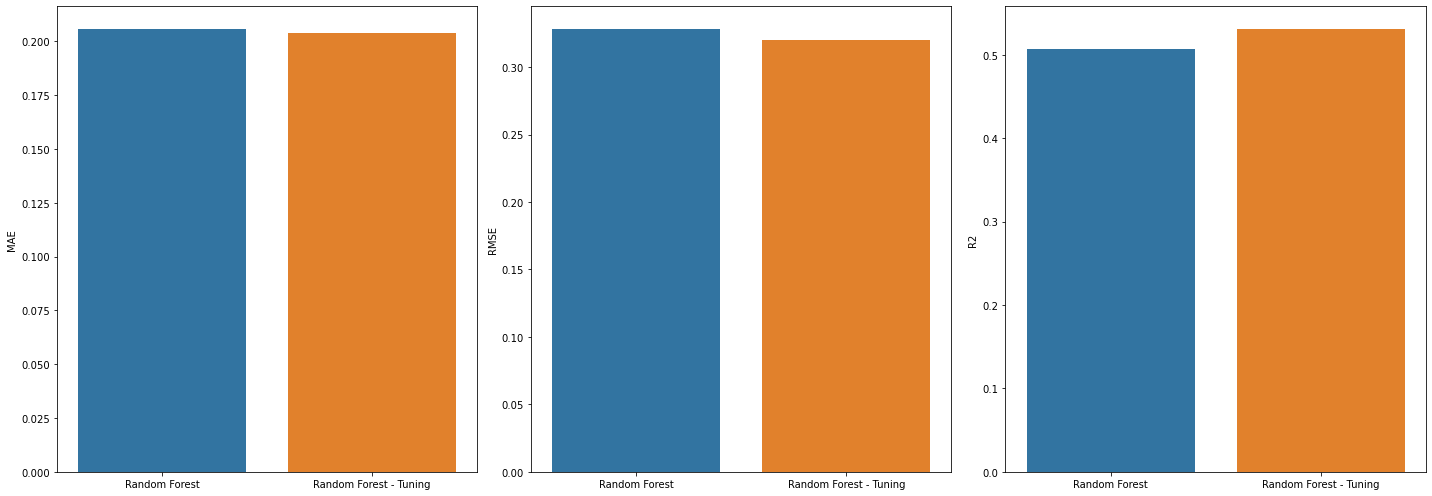

In [105]:
plt.figure(figsize=(20,7))
    
for i in range(0, before_after_tuning.shape[1]):
    plt.subplot(1, before_after_tuning.shape[1], i+1)
    sns.barplot(x=before_after_tuning.index, y=before_after_tuning.columns[i], data=before_after_tuning)
    plt.tight_layout()



In [106]:
# # save session 
# import dill
# dill.dump_session('Homework.db')

# Nomor 4

In [11]:
# # load session 
# import dill
# dill.load_session('Homework.db')